In [ ]:
import pandas as pd

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import scaffolding
from uuid import UUID

%matplotlib inline

In [ ]:
year = None
month = None
program = "default"
study_type = "program"
mode_of_interest = "e-bike"
include_test_users = True

## Load the programs

In [ ]:
# Split UUIDs by program
program_uuid_map = {}
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    if program in program_uuid_map.keys():
        program_uuid_map[program].append(str(ue['uuid']))
    else:
        print(f"Found new program {program}, creating new list")
        program_uuid_map[program] = []
        program_uuid_map[program].append(str(ue['uuid']))

In [ ]:
uuid_program_list = []
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    uuid_program_list.append({"program": program, "opcode": ue["user_email"], "user_id_str": str(ue['uuid'])})

In [ ]:
uuid_program_df = pd.DataFrame.from_dict(uuid_program_list)
uuid_program_df.head()

In [ ]:
from collections import defaultdict

In [ ]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r dic_re
%store -r dic_pur

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)

## Load the trip table

In [ ]:
expanded_ct, file_suffix, quality_text, debug_df = scaffolding.load_viz_notebook_data(year,
                                                                            month,
                                                                            program,
                                                                            study_type,
                                                                            dic_re,
                                                                            dic_pur=dic_pur,
                                                                            include_test_users=include_test_users)

In [ ]:
expanded_ct["user_id_str"] = expanded_ct.user_id.apply(lambda u: str(u))
len(expanded_ct.user_id_str.unique())

## Combine program and trip tables

In [1]:
import pandas as pd
from uuid import UUID
import json
from shapely.geometry import MultiPoint

%matplotlib inline

In [ ]:
trip_program_df = expanded_ct.merge(uuid_program_df, on="user_id_str")

In [2]:
trip_program_df = pd.read_csv(r"C:\Users\dakcicek\Documents\GitHub\ceo_analysis\viz_scripts\filtered_merged_trips_2.csv")

In [3]:
trip_program_df["distance_km"] = trip_program_df.distance / 1000

In [ ]:
trip_program_df.dtypes

In [ ]:
trip_program_df.sample(n=50, random_state=123)[["program", "user_id_str", "opcode", "_id", "start_fmt_time", "end_fmt_time", "distance_km", "mode_confirm"]]

In [ ]:
%conda install geopandas

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
from shapely.geometry import shape

def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str.replace("'", '"')))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None

In [5]:
trip_program_df["start_loc"] = trip_program_df["start_loc"].apply(parse_geom)
#trip_program_df_gdf = gpd.GeoDataFrame(trip_program_df, geometry="start_loc")
trip_program_df["end_loc"] = trip_program_df["end_loc"].apply(parse_geom)
#trip_program_df_gdf = gpd.GeoDataFrame(trip_program_df, geometry="end_loc")
print(trip_program_df.head())

                        source      end_ts                      end_fmt_time  \
0  DwellSegmentationTimeFilter  1629871457  2021-08-25T00:04:16.898000-06:00   
1  DwellSegmentationTimeFilter  1629900322  2021-08-25T08:05:21.637000-06:00   
2  DwellSegmentationTimeFilter  1629928946  2021-08-25T16:02:26.349000-06:00   
3  DwellSegmentationTimeFilter  1629932515         2021-08-25T17:01:55-06:00   
4  DwellSegmentationTimeFilter  1629934536  2021-08-25T17:35:36.408000-06:00   

                           end_loc                  raw_trip  \
0  POINT (-107.8611981 37.2751867)  6125ee087a779613738ad16c   
1  POINT (-107.8810375 37.2741646)  61265e8906e4c6c000ae237a   
2  POINT (-107.8805793 37.2759903)  6126cefe5e9a33350c3addfa   
3  POINT (-107.8812319 37.2741806)  6126dd19626dbb8489f593a3   
4  POINT (-107.8611821 37.2751648)  6126dd19626dbb8489f593a5   

                              start_ts                    start_fmt_time  \
0  2021-08-25 05:55:19.566900969+00:00  2021-08-24T23:55:1

In [6]:
trip_program_df['start_end'] = trip_program_df.apply(lambda row: MultiPoint([row['start_loc'], row['end_loc']]), axis=1) #Create a multipoint column

C:\Users\dakcicek\Anaconda3\envs\tsdc_ops\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\dakcicek\Anaconda3\envs\tsdc_ops\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\dakcicek\Anaconda3\envs\tsdc_ops\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
trip_program_df

In [7]:
trip_program_df_gdf = gpd.GeoDataFrame(trip_program_df, geometry="start_end")

In [8]:
trip_program_df_gdf.crs is None

True

In [9]:
trip_program_df_gdf = trip_program_df_gdf.set_crs(4269, allow_override=True)

In [10]:
trip_program_df_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

## Load shape files

In [2]:
import geopandas as gpd

In [11]:
denver_boundary = gpd.read_file("geom/denver_uza.shp")

In [ ]:
# denver_boundary.to_json()

<AxesSubplot:>

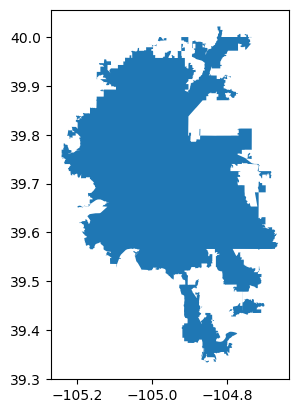

In [12]:
denver_boundary.plot()

In [13]:
denver_pixels = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\denver_pixels_ca.shp")

In [14]:
denver_pixels

,id,left,top,right,bottom,geometry
0,2733.0,-1.168837e+07,4.837141e+06,-1.168737e+07,4.836141e+06,"POLYGON ((-104.99843 39.80152, -104.98945 39.8..."
1,2734.0,-1.168837e+07,4.836141e+06,-1.168737e+07,4.835141e+06,"POLYGON ((-104.99843 39.79461, -104.98945 39.7..."
2,2735.0,-1.168837e+07,4.835141e+06,-1.168737e+07,4.834141e+06,"POLYGON ((-104.99843 39.78771, -104.98945 39.7..."
3,2720.0,-1.168837e+07,4.850141e+06,-1.168737e+07,4.849141e+06,"POLYGON ((-104.99843 39.89118, -104.98945 39.8..."
4,2721.0,-1.168837e+07,4.849141e+06,-1.168737e+07,4.848141e+06,"POLYGON ((-104.99843 39.88428, -104.98945 39.8..."
...,...,...,...,...,...,...
3453,2728.0,-1.168837e+07,4.842141e+06,-1.168737e+07,4.841141e+06,"POLYGON ((-104.99843 39.83601, -104.98945 39.8..."
3454,2729.0,-1.168837e+07,4.841141e+06,-1.168737e+07,4.840141e+06,"POLYGON ((-104.99843 39.82912, -104.98945 39.8..."
3455,2730.0,-1.168837e+07,4.840141e+06,-1.168737e+07,4.839141e+06,"POLYGON ((-104.99843 39.82222, -104.98945 39.8..."
3456,2731.0,-1.168837e+07,4.839141e+06,-1.168737e+07,4.838141e+06,"POLYGON ((-104.99843 39.81532, -104.98945 39.8..."


<AxesSubplot:>

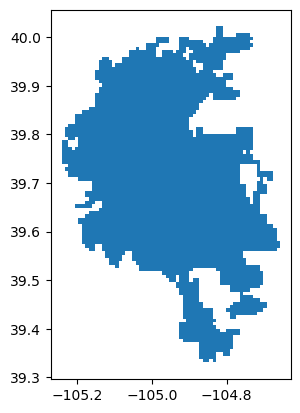

In [15]:
denver_pixels.plot()

## Prepping dataframes for plotting

In [16]:
all_start_end_points = trip_program_df.start_loc.append(trip_program_df.end_loc)
all_start_end_points

0                      POINT (-107.8805606 37.276007)
1                     POINT (-107.8664569 37.2708361)
2                     POINT (-107.8810375 37.2741646)
3                     POINT (-107.8805793 37.2759903)
4                     POINT (-107.8812319 37.2741806)
                             ...                     
61491    POINT (-106.3822104003052 39.64329193202236)
61492    POINT (-106.3828356765339 39.64318045024082)
61493    POINT (-106.3806151333298 39.64595539021802)
61494    POINT (-106.3824186718631 39.64325160537167)
61495    POINT (-106.3837965676944 39.64332162452388)
Length: 122992, dtype: object

In [17]:
import shapely as shp

In [ ]:
# I wanted to use shapely's from_geojson but it doesn't seem to be supported in this version
all_geo_start_end_points = gpd.GeoSeries(all_start_end_points.apply(lambda p: shp.geometry.Point(p['coordinates'])), crs="EPSG:4269")

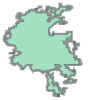

In [18]:
denver_boundary.geometry.iloc[0]

In [ ]:
all_start_or_end_within = all_geo_start_end_points[all_geo_start_end_points.within(denver_boundary.geometry.iloc[0])]

In [20]:
all_start_or_end_within = trip_program_df_gdf[trip_program_df_gdf.within(denver_boundary.geometry.iloc[0])]

In [21]:
import matplotlib.pyplot as plt

<AxesSubplot:>

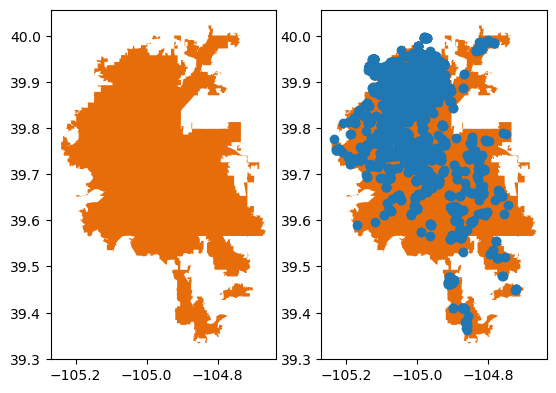

In [25]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2)
denver_boundary.plot(color="#E66D0A", ax=ax_arr[0])
denver_boundary.plot(color="#E66D0A", ax=ax_arr[1])
all_start_or_end_within.plot(ax=ax_arr[1])

<AxesSubplot:>

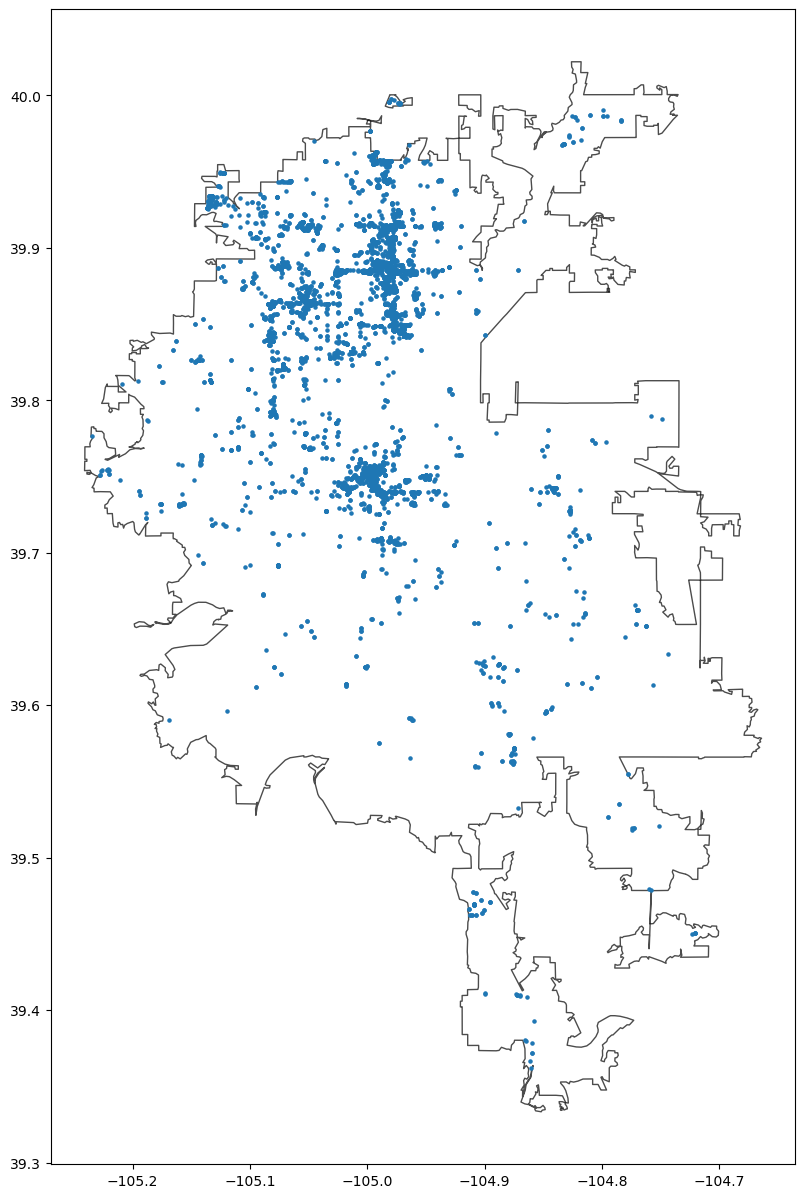

In [39]:
fig, ax = plt.subplots (figsize = (15,15))
denver_boundary.plot(ax = ax, alpha = 0.7, color = "white", edgecolor='black')
all_start_or_end_within.plot(ax = ax, markersize=5)

In [ ]:
e_bike_trips = trip_program_df[trip_program_df.mode_confirm == 'pilot_ebike']; len(e_bike_trips)

In [22]:
e_bike_trips = trip_program_df_gdf[trip_program_df_gdf.mode_confirm == 'pilot_ebike']; len(e_bike_trips)

17348

In [23]:
trip_program_df_gdf['mode_confirm'].unique()

array(['pilot_ebike', 'shared_ride', 'walk', 'skateboard', 'drove_alone',
       'bike', 'bus', 'free_shuttle', 'bikeshare', nan, 'taxi', 'train',
       'scootershare'], dtype=object)

In [ ]:
car_like_trips = trip_program_df.query('mode_confirm == "drove_alone" | mode_confirm == "shared_ride" | mode_confirm == "taxi"'); len(car_like_trips)

In [24]:
car_like_trips = trip_program_df_gdf.query('mode_confirm == "drove_alone" | mode_confirm == "shared_ride" | mode_confirm == "taxi"'); len(car_like_trips)

30767

In [25]:
e_bike_start_end_points = e_bike_trips.start_loc.append(e_bike_trips.end_loc); len(e_bike_start_end_points)

34696

In [ ]:
e_bike_geo_start_end_points = gpd.GeoSeries(e_bike_start_end_points.apply(lambda p: shp.geometry.Point(p['coordinates'])), crs="EPSG:4269")

In [ ]:
e_bike_start_or_end_within = e_bike_geo_start_end_points[e_bike_geo_start_end_points.within(denver_boundary.geometry.iloc[0])]

In [31]:
e_bike_start_or_end_within = e_bike_trips[e_bike_trips.within(denver_boundary.geometry.iloc[0])]

In [26]:
car_like_start_end_points = car_like_trips.start_loc.append(car_like_trips.end_loc); len(car_like_start_end_points)

61534

In [ ]:
car_like_geo_start_end_points = gpd.GeoSeries(car_like_start_end_points.apply(lambda p: shp.geometry.Point(p['coordinates'])), crs="EPSG:4269")

In [ ]:
car_like_start_or_end_within = car_like_geo_start_end_points[car_like_geo_start_end_points.within(denver_boundary.geometry.iloc[0])]

In [27]:
car_like_start_or_end_within = car_like_trips[car_like_trips.within(denver_boundary.geometry.iloc[0])]

### General plotting of start/end points

<AxesSubplot:>

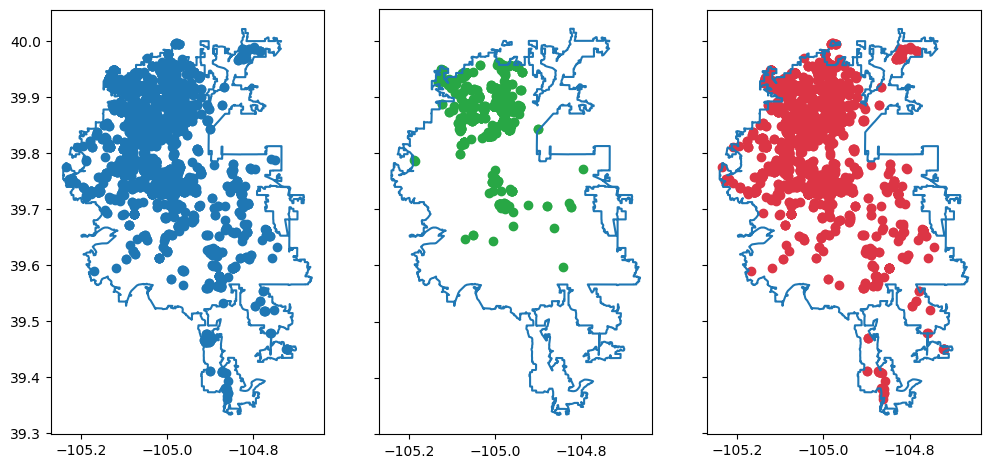

In [35]:
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
denver_boundary.boundary.plot(ax=ax_arr[0])
all_start_or_end_within.plot(ax=ax_arr[0])
denver_boundary.boundary.plot(ax=ax_arr[1])
e_bike_start_or_end_within.plot(color="#28a745", ax=ax_arr[1])
denver_boundary.boundary.plot(ax=ax_arr[2])
car_like_start_or_end_within.plot(color="#dc3545", ax=ax_arr[2])

<AxesSubplot:>

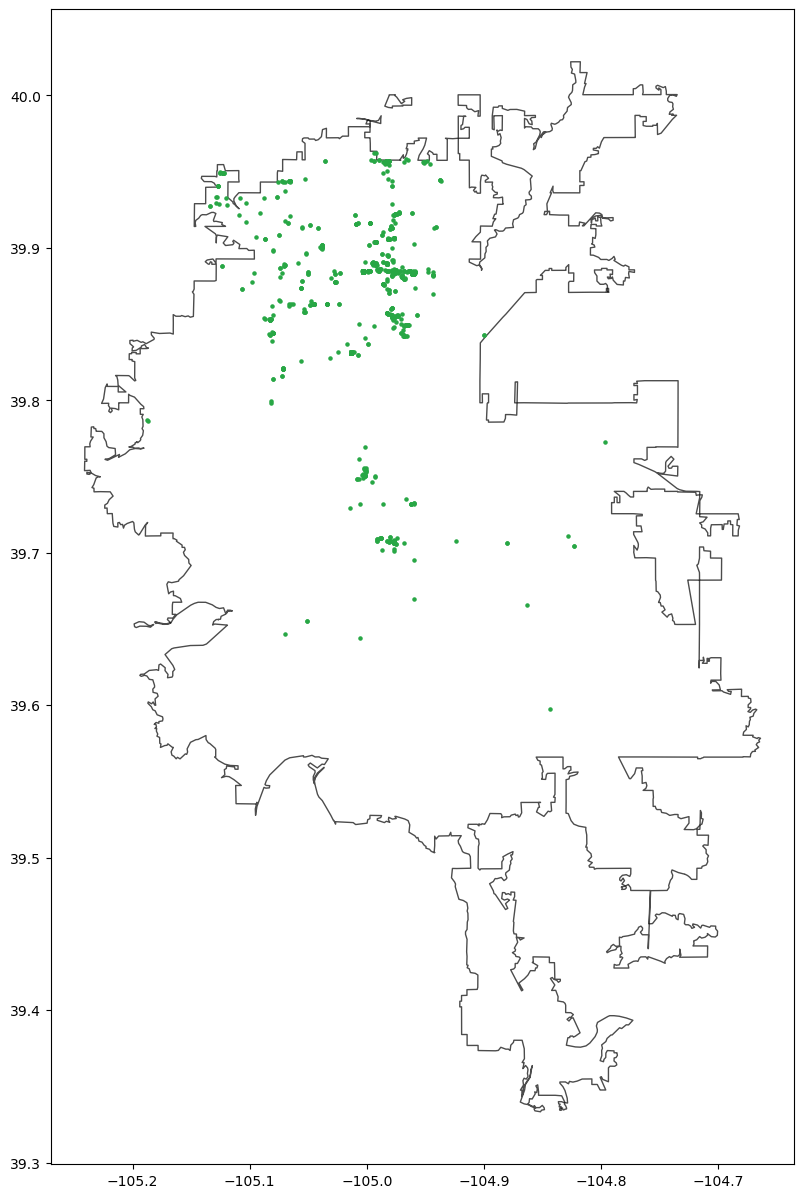

In [40]:
fig, ax = plt.subplots (figsize = (15,15))
denver_boundary.plot(ax = ax, alpha = 0.7, color = "white", edgecolor='black')
e_bike_start_or_end_within.plot(ax = ax, color="#28a745",markersize=5)

<AxesSubplot:>

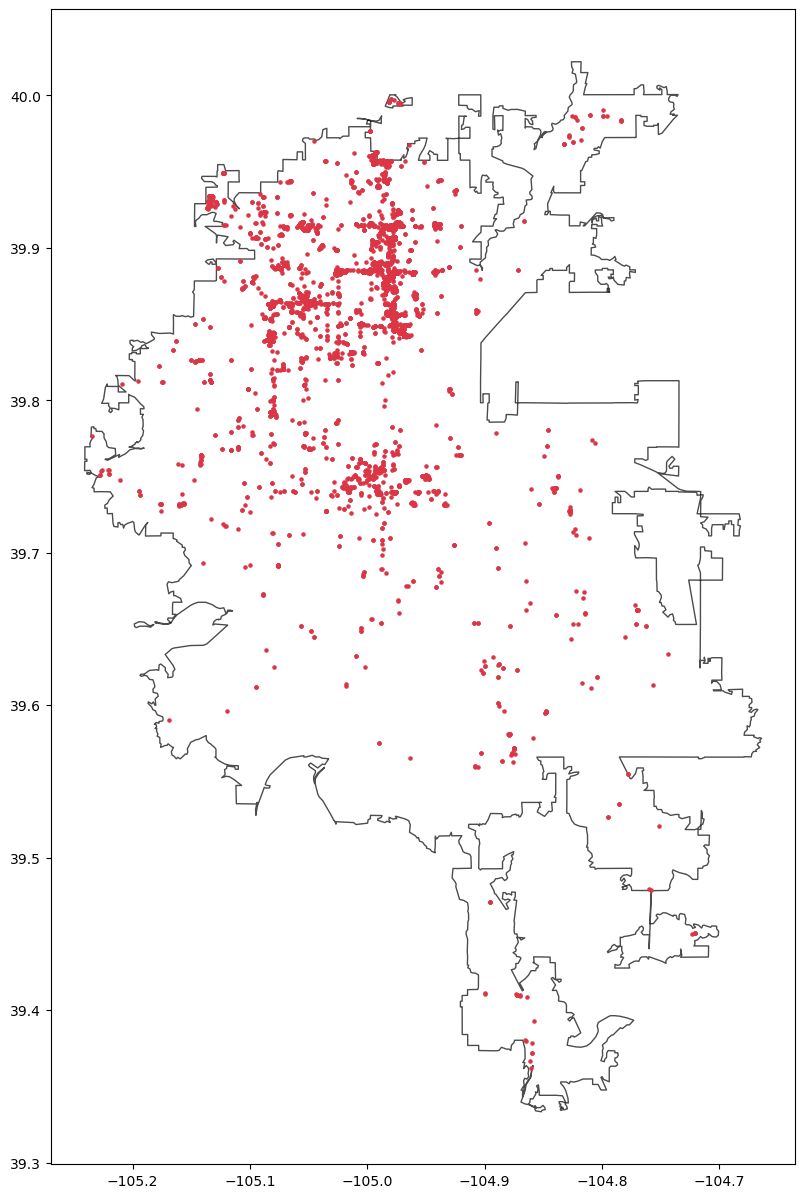

In [41]:
fig, ax = plt.subplots (figsize = (15,15))
denver_boundary.plot(ax = ax, alpha = 0.7, color = "white", edgecolor='black')
car_like_start_or_end_within.plot(ax = ax, color="#dc3545",markersize=5)

### Heatmap using folium

Example from: https://stackoverflow.com/a/65756840/4040267

In [43]:
import folium
import folium.plugins as fpl

In [44]:
denver_boundary.representative_point()

C:\Users\dakcicek\Anaconda3\envs\tsdc_ops\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.representative_point(self.data), crs=self.crs)


0    POINT (-104.96168 39.67707)
dtype: geometry

In [17]:
import numpy as np

In [ ]:
all_start_or_end_within.apply(lambda p: [p.y, p.x])

In [ ]:
all_start_or_end_within.apply(lambda p: [p.y, p.x])

In [ ]:
np.array([all_start_or_end_within.x, all_start_or_end_within.y])

In [ ]:
map = folium.Map(
    location=(39.67707, -104.96168),
    zoom_start=11
)
fpl.HeatMap(all_start_or_end_within.apply(lambda p: [p.y, p.x])).add_to(map)
map

In [ ]:
import branca.element as bre

In [ ]:
all_map = folium.Map(
    location=(39.67707, -104.96168),
    zoom_start=11
)
fpl.HeatMap(all_start_or_end_within.apply(lambda p: [p.y, p.x])).add_to(all_map)

e_bike_map = folium.Map(
    location=(39.67707, -104.96168),
    zoom_start=11
)
fpl.HeatMap(e_bike_start_or_end_within.apply(lambda p: [p.y, p.x])).add_to(e_bike_map)

car_like_map = folium.Map(
    location=(39.67707, -104.96168),
    zoom_start=11
)
fpl.HeatMap(car_like_start_or_end_within.apply(lambda p: [p.y, p.x])).add_to(car_like_map)


fig = bre.Figure()
fig.add_subplot(1,3,1).add_child(all_map)
fig.add_subplot(1,3,2).add_child(e_bike_map)
fig.add_subplot(1,3,3).add_child(car_like_map)

In [ ]:
#Import the Lib
from folium.plugins import HeatMap

#Make the list of Lat an Lng
lat = data.latitude.tolist()
lng = data.longitude.tolist()

#Create the Map
map = folium.Map(
    location=[39.67707, -104.96168],
    tiles='cartodbdark_matter',
    zoom_start=11
)
HeatMap(list(zip(lat, lng))).add_to(map)
map

### Heatmap using geopandas

Example from: https://gist.github.com/perrygeo/c426355e40037c452434

In [48]:
from scipy import ndimage

In [49]:
denver_bounds_extent = (denver_boundary.bounds)[["minx", "maxx", "maxy", "miny"]].values.tolist()[0]

In [50]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='viridis', ax=None, bounds=None):
    heatmap, xedges, yedges = np.histogram2d(d.y, d.x, bins=bins)
    if bounds is None:
        extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
        print(extent)
    else:
        extent = bounds
        print(extent)

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    # heatmap = ndimage.filters.gaussian_filter(heatmap, smoothing, mode='nearest')
    
    if ax is None:
        plt.imshow(logheatmap, cmap=cmap, extent=extent)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.show()
    else:
        ax.imshow(logheatmap, cmap=cmap, extent=extent)
        ax.invert_yaxis()

In [ ]:
heatmap(all_start_or_end_within)

In [ ]:
fig, ax_arr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))
denver_boundary.boundary.plot(ax=ax_arr[0])
heatmap(all_start_or_end_within, ax=ax_arr[0], bounds=denver_bounds_extent)
denver_boundary.boundary.plot(ax=ax_arr[1])
heatmap(e_bike_start_or_end_within, ax=ax_arr[1], bounds=denver_bounds_extent)
denver_boundary.boundary.plot(ax=ax_arr[2])
heatmap(car_like_start_or_end_within, ax=ax_arr[2], bounds=denver_bounds_extent)

### Using seaborn

https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.kdeplot(x=all_start_or_end_within.x, y=all_start_or_end_within.y, color='g', shade=True)
denver_boundary.boundary.plot(ax=ax)

In [ ]:
fig, ax_arr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))
denver_boundary.boundary.plot(ax=ax_arr[0])
sns.kdeplot(x=all_start_or_end_within.x, y=all_start_or_end_within.y, ax=ax_arr[0], color='g', shade=True)
denver_boundary.boundary.plot(ax=ax_arr[1])
sns.kdeplot(x=e_bike_start_or_end_within.x, y=e_bike_start_or_end_within.y, ax=ax_arr[1], color='g', shade=True)
denver_boundary.boundary.plot(ax=ax_arr[2])
sns.kdeplot(x=car_like_start_or_end_within.x, y=car_like_start_or_end_within.y, ax=ax_arr[2], color='g', shade=True)

In [ ]:
all_geo_start_end_points.head()

### Plot all e-bike trajectories (note that this will take several hours)

In [ ]:
def get_points_for_trip(user_id, trip_id):
    ts = esta.TimeSeries.get_time_series(user_id)
    return ts.get_data_df("analysis/recreated_location",
                         time_query=esda.get_time_query_for_trip_like("analysis/confirmed_trip", trip_id))

In [ ]:
# e_bike_all_trip_points = e_bike_trips.iloc[0:5].apply(lambda t: get_points_for_trip(t.user_id, t._id), axis=1)
e_bike_all_trip_points = e_bike_trips.apply(lambda t: get_points_for_trip(t.user_id, t._id), axis=1)

In [ ]:
import functools

In [ ]:
e_bike_all_points = functools.reduce(lambda x, y: x.append(y), e_bike_all_trip_points)

In [ ]:
e_bike_all_points["loc"]

In [ ]:
e_bike_all_points_gs = gpd.GeoSeries(e_bike_all_points["loc"].apply(lambda p: shp.geometry.Point(p['coordinates'])), crs="EPSG:4269")

In [ ]:
e_bike_all_points_within = e_bike_all_points_gs[e_bike_all_points_gs.within(denver_boundary.geometry.iloc[0])]

In [ ]:
fig, ax_arr = plt.subplots(nrows=1, ncols=1, figsize=(24,12))
# durham_boundary.plot(color="#E66D0A", ax=ax_arr[0])
denver_boundary.boundary.plot(ax=ax_arr)
e_bike_all_points_within.plot(ax=ax_arr, markersize=1)

### Final, most complicated version using pixels, and computing the ratio of e-bike to car_like trips

In [28]:
# First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts(pixel_polygon):
    all_trip_count = np.count_nonzero(all_geo_start_end_points.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_geo_start_end_points.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_geo_start_end_points.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

In [29]:
# First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts(pixel_polygon):
    all_trip_count = np.count_nonzero(all_start_or_end_within.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

#### Test with a small dataset

In [ ]:
test_pixels = denver_pixels.head(n=50).copy()

In [ ]:
test_pixels

In [ ]:
test_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = test_pixels.geometry.apply(lambda pp: get_counts(pp))

In [ ]:
test_pixels.head()

In [ ]:
fig, ax_arr = plt.subplots(nrows=3, ncols=1, figsize=(12,6), sharex=True, sharey=True)
test_pixels.plot(column="all_trip_count", legend=True, ax=ax_arr[0])
test_pixels.plot(column="e_bike_trip_count", legend=True, ax=ax_arr[1])
test_pixels.plot(column="car_like_trip_count", legend=True, ax=ax_arr[2])

In [ ]:
test_pixels["e_bike_2_car_like"] = test_pixels.e_bike_trip_count / test_pixels.car_like_trip_count

In [ ]:
test_pixels.head()

In [ ]:
test_pixels.e_bike_2_car_like.dropna()

In [ ]:
ax = denver_boundary.boundary.plot()
test_pixels.plot(column="e_bike_2_car_like", ax=ax, legend=True)

### And now for the final version

In [32]:
denver_pixels_all = denver_pixels.copy()
denver_pixels_all[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = denver_pixels_all.geometry.apply(lambda pp: get_counts(pp))

In [33]:
denver_pixels_all

,id,left,top,right,bottom,geometry,all_trip_count,e_bike_trip_count,car_like_trip_count
0,2733.0,-1.168837e+07,4.837141e+06,-1.168737e+07,4.836141e+06,"POLYGON ((-104.99843 39.80152, -104.98945 39.8...",0,0,0
1,2734.0,-1.168837e+07,4.836141e+06,-1.168737e+07,4.835141e+06,"POLYGON ((-104.99843 39.79461, -104.98945 39.7...",0,0,0
2,2735.0,-1.168837e+07,4.835141e+06,-1.168737e+07,4.834141e+06,"POLYGON ((-104.99843 39.78771, -104.98945 39.7...",0,0,0
3,2720.0,-1.168837e+07,4.850141e+06,-1.168737e+07,4.849141e+06,"POLYGON ((-104.99843 39.89118, -104.98945 39.8...",17,11,3
4,2721.0,-1.168837e+07,4.849141e+06,-1.168737e+07,4.848141e+06,"POLYGON ((-104.99843 39.88428, -104.98945 39.8...",0,0,0
...,...,...,...,...,...,...,...,...,...
3453,2728.0,-1.168837e+07,4.842141e+06,-1.168737e+07,4.841141e+06,"POLYGON ((-104.99843 39.83601, -104.98945 39.8...",0,0,0
3454,2729.0,-1.168837e+07,4.841141e+06,-1.168737e+07,4.840141e+06,"POLYGON ((-104.99843 39.82912, -104.98945 39.8...",2,0,2
3455,2730.0,-1.168837e+07,4.840141e+06,-1.168737e+07,4.839141e+06,"POLYGON ((-104.99843 39.82222, -104.98945 39.8...",0,0,0
3456,2731.0,-1.168837e+07,4.839141e+06,-1.168737e+07,4.838141e+06,"POLYGON ((-104.99843 39.81532, -104.98945 39.8...",0,0,0


<AxesSubplot:>

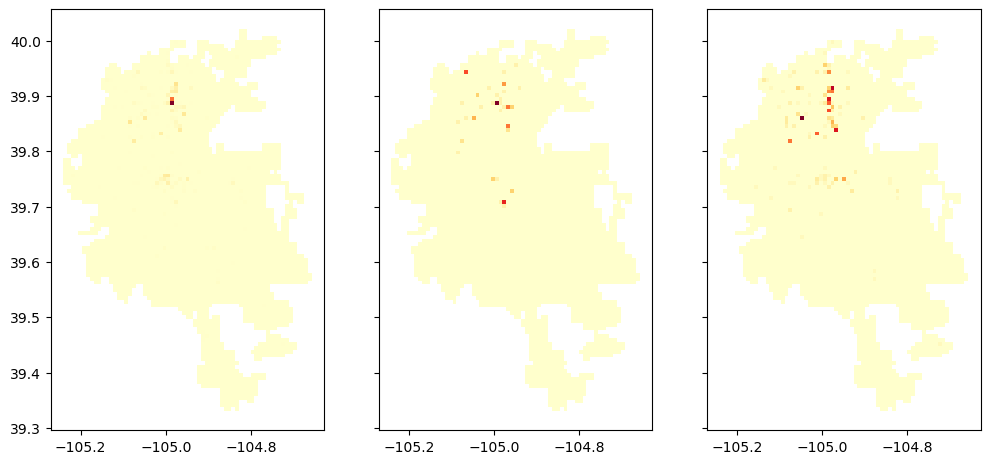

In [34]:
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
denver_pixels_all.plot(column="all_trip_count", ax=ax_arr[0], cmap="YlOrRd")
denver_pixels_all.plot(column="e_bike_trip_count", ax=ax_arr[1], cmap="YlOrRd")
denver_pixels_all.plot(column="car_like_trip_count", ax=ax_arr[2], cmap="YlOrRd")

In [35]:
denver_pixels_all["e_bike_2_car_like"] = denver_pixels_all.e_bike_trip_count / denver_pixels_all.car_like_trip_count

In [36]:
denver_pixels_all.replace(np.inf, denver_pixels_all.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)

In [37]:
denver_pixels_all[denver_pixels_all.e_bike_2_car_like > 5]

,id,left,top,right,bottom,geometry,all_trip_count,e_bike_trip_count,car_like_trip_count,e_bike_2_car_like


In [38]:
denver_pixels_all

,id,left,top,right,bottom,geometry,all_trip_count,e_bike_trip_count,car_like_trip_count,e_bike_2_car_like
0,2733.0,-1.168837e+07,4.837141e+06,-1.168737e+07,4.836141e+06,"POLYGON ((-104.99843 39.80152, -104.98945 39.8...",0,0,0,NaN
1,2734.0,-1.168837e+07,4.836141e+06,-1.168737e+07,4.835141e+06,"POLYGON ((-104.99843 39.79461, -104.98945 39.7...",0,0,0,NaN
2,2735.0,-1.168837e+07,4.835141e+06,-1.168737e+07,4.834141e+06,"POLYGON ((-104.99843 39.78771, -104.98945 39.7...",0,0,0,NaN
3,2720.0,-1.168837e+07,4.850141e+06,-1.168737e+07,4.849141e+06,"POLYGON ((-104.99843 39.89118, -104.98945 39.8...",17,11,3,3.666667
4,2721.0,-1.168837e+07,4.849141e+06,-1.168737e+07,4.848141e+06,"POLYGON ((-104.99843 39.88428, -104.98945 39.8...",0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
3453,2728.0,-1.168837e+07,4.842141e+06,-1.168737e+07,4.841141e+06,"POLYGON ((-104.99843 39.83601, -104.98945 39.8...",0,0,0,NaN
3454,2729.0,-1.168837e+07,4.841141e+06,-1.168737e+07,4.840141e+06,"POLYGON ((-104.99843 39.82912, -104.98945 39.8...",2,0,2,0.000000
3455,2730.0,-1.168837e+07,4.840141e+06,-1.168737e+07,4.839141e+06,"POLYGON ((-104.99843 39.82222, -104.98945 39.8...",0,0,0,NaN
3456,2731.0,-1.168837e+07,4.839141e+06,-1.168737e+07,4.838141e+06,"POLYGON ((-104.99843 39.81532, -104.98945 39.8...",0,0,0,NaN


<AxesSubplot:>

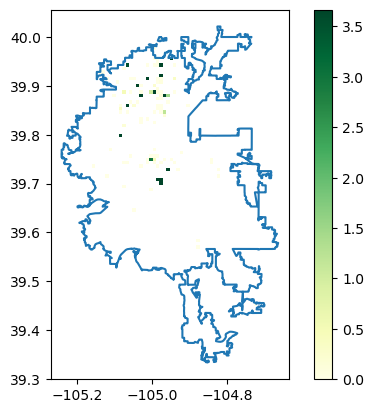

In [39]:
ax = denver_boundary.boundary.plot()
denver_pixels_all.plot(column="e_bike_2_car_like", ax=ax, cmap="YlGn", legend=True)

<AxesSubplot:ylabel='Frequency'>

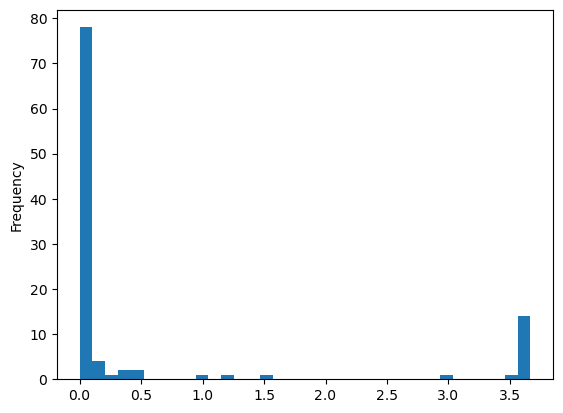

In [40]:
denver_pixels_all.e_bike_2_car_like.dropna().plot(kind="hist", bins=35)

In [41]:
np.count_nonzero(denver_pixels_all.e_bike_2_car_like < 0.5), np.count_nonzero(denver_pixels_all.e_bike_2_car_like >= 0.5)

(85, 21)

In [ ]:
108 * 100 / 658

In [42]:
denver_pixels_all["e_bike_better"] = pd.Categorical(denver_pixels_all.e_bike_2_car_like >= 1)

<AxesSubplot:>

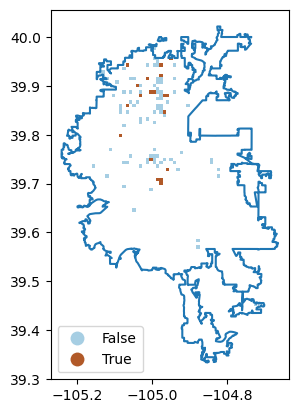

In [43]:
ax = denver_boundary.boundary.plot()
denver_pixels_all.dropna(axis='rows', how='any').plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:title={'center':'Pixels where e-bikes are used more often than driving'}, ylabel='id'>

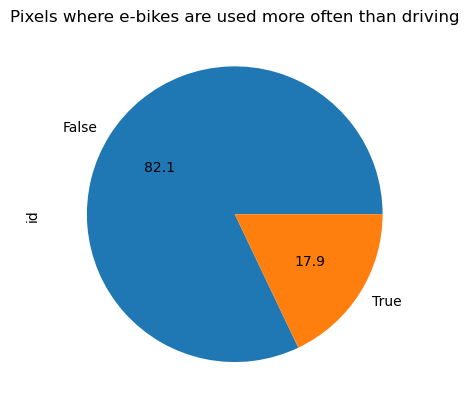

In [44]:
denver_pixels_all.dropna().groupby("e_bike_better").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bikes are used more often than driving")

In [45]:
denver_pixels_all["e_bike_gt_50_pct"] = pd.Categorical(denver_pixels_all.e_bike_2_car_like >= 0.5)

<AxesSubplot:title={'center':'Pixels where e-bike trips are least 50% of driving trips'}, ylabel='id'>

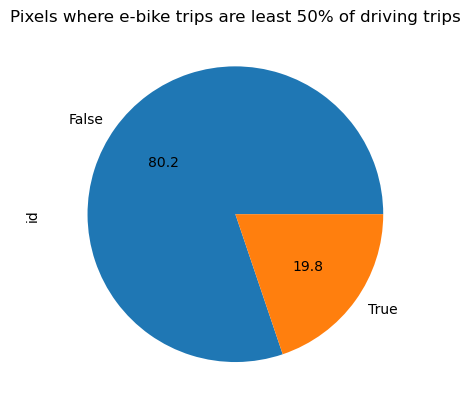

In [46]:
denver_pixels_all.dropna().groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bike trips are least 50% of driving trips")

## Another complex check - does this differ across programs

In [ ]:
def get_endpoints_within(trip_df):
    start_end_points = trip_df.start_loc.append(trip_df.end_loc)
    geo_start_end_points = gpd.GeoSeries(start_end_points.apply(lambda p: shp.geometry.Point(p['coordinates'])), crs="EPSG:4269")
    start_or_end_within = geo_start_end_points[geo_start_end_points.within(denver_boundary.geometry.iloc[0])]
    return start_or_end_within

In [ ]:
def get_all_e_bike_car_like(trip_df):
    return {"all": get_endpoints_within(trip_df),
            "e_bike": get_endpoints_within(trip_df.query('mode_confirm == "pilot_ebike"')),
            "car_like": get_endpoints_within(trip_df.query('mode_confirm == "drove_alone" | mode_confirm == "shared_ride" | mode_confirm == "taxi"'))
           }

In [ ]:
sc_trips_split = get_all_e_bike_car_like(trip_program_df.query("program == 'sc'"))

In [ ]:
prepilot_trips_split = get_all_e_bike_car_like(trip_program_df.query("program == 'prepilot'"))

In [ ]:
def get_kde_plots(trips_split):
    fig, ax_arr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))
    denver_boundary.boundary.plot(ax=ax_arr[0])
    sns.kdeplot(x=trips_split["all"].x, y=trips_split["all"].y, ax=ax_arr[0], color='g', shade=True)
    denver_boundary.boundary.plot(ax=ax_arr[1])
    sns.kdeplot(x=trips_split["e_bike"].x, y=trips_split["e_bike"].y, ax=ax_arr[1], color='g', shade=True)
    denver_boundary.boundary.plot(ax=ax_arr[2])
    sns.kdeplot(x=trips_split["car_like"].x, y=trips_split["car_like"].y, ax=ax_arr[2], color='g', shade=True)
    # return fig

In [ ]:
get_kde_plots(sc_trips_split)

In [ ]:
get_kde_plots(prepilot_trips_split)

In [ ]:
def get_scatter_plots(trips_split):
    fig, ax_arr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))
    denver_boundary.boundary.plot(ax=ax_arr[0])
    trips_split["all"].plot(ax=ax_arr[0])
    ax_arr[0].set_title("all trips")
    denver_boundary.boundary.plot(ax=ax_arr[1])
    trips_split["e_bike"].plot(color="#28a745", ax=ax_arr[1])
    ax_arr[1].set_title("e-bike trips")
    denver_boundary.boundary.plot(ax=ax_arr[2])
    trips_split["car_like"].plot(color="#dc3545", ax=ax_arr[2])
    ax_arr[2].set_title("car trips")
    # return fig

In [ ]:
get_scatter_plots(sc_trips_split)

In [ ]:
get_scatter_plots(prepilot_trips_split)

In [ ]:
# First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_trips_split(trips_split, pixel_polygon):
    all_trip_count = np.count_nonzero(trips_split["all"].within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(trips_split["e_bike"].within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(trips_split["car_like"].within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

In [ ]:
def get_pixel_stats(trips_split):
    curr_pixel_stats = denver_pixels.copy()
    curr_pixel_stats[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = curr_pixel_stats.geometry.apply(lambda pp: get_counts_trips_split(trips_split, pp))
    curr_pixel_stats["e_bike_2_car_like"] = curr_pixel_stats.e_bike_trip_count / curr_pixel_stats.car_like_trip_count
    curr_pixel_stats["e_bike_better"] = pd.Categorical(curr_pixel_stats.e_bike_2_car_like >= 1)
    curr_pixel_stats["e_bike_gt_50_pct"] = pd.Categorical(curr_pixel_stats.e_bike_2_car_like >= 0.5)
    return curr_pixel_stats

In [ ]:
sc_pixel_stats = get_pixel_stats(sc_trips_split)

In [ ]:
def show_pixel_stats(pixel_stats):
    fig, ax_arr = plt.subplots(nrows=1, ncols=2)
    denver_boundary.boundary.plot(ax=ax_arr[0])
    pixel_stats.dropna(axis='rows', how='any').plot(column = "e_bike_better", ax = ax_arr[0], legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))
    denver_boundary.boundary.plot(ax=ax_arr[1])
    pixel_stats.dropna(axis='rows', how='any').plot(column = "e_bike_gt_50_pct", ax = ax_arr[1], legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))    

In [ ]:
show_pixel_stats(sc_pixel_stats)

In [ ]:
def show_pixel_percents(pixel_stats):
    fig, ax_arr = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
    pixel_stats.dropna().groupby("e_bike_better").count().id.plot(kind="pie", ax=ax_arr[0], autopct='%.1f', title="e-bikes are used more often than driving")
    pixel_stats.dropna().groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", ax=ax_arr[1], autopct='%.1f', title="e-bike trips are least 50% of driving trips")
    ax_arr[0].set_ylabel("% of pixels")

In [ ]:
show_pixel_percents(sc_pixel_stats)

In [ ]:
prepilot_pixel_stats = get_pixel_stats(prepilot_trips_split)

In [ ]:
show_pixel_stats(prepilot_pixel_stats)

In [ ]:
show_pixel_percents(prepilot_pixel_stats)

In [ ]:
other_programs_split = get_all_e_bike_car_like(trip_program_df.query('program != "sc" & program != "prepilot" & program != "stage"'))

In [ ]:
get_scatter_plots(other_programs_split)

In [ ]:
other_programs_pixel_stats = get_pixel_stats(other_programs_split)

In [ ]:
show_pixel_stats(other_programs_pixel_stats)

In [ ]:
show_pixel_percents(other_programs_pixel_stats)

## Experimenting with whether we can associate other fields with the start_end_loc points

In [ ]:
start_loc_df = trip_program_df[["program", "mode_confirm", "start_loc"]].copy()
start_loc_df["type"] = ["start"] * len(start_loc_df)
start_loc_df.rename(columns = {"start_loc": "location"}, inplace=True)
start_loc_df.head()

In [ ]:
end_loc_df = trip_program_df[["program", "mode_confirm", "end_loc"]].copy()
end_loc_df["type"] = ["end"] * len(end_loc_df)
end_loc_df.rename(columns = {"end_loc": "location"}, inplace=True)
end_loc_df.head()

In [ ]:
loc_program_df = gpd.GeoDataFrame(start_loc_df.append(end_loc_df))
loc_program_geodf = loc_program_df.set_geometry(loc_program_df['location'].apply(lambda p: shp.geometry.Point(p['coordinates'])), crs="EPSG:4269")
loc_program_geodf.head()

In [ ]:
program_endpoints_within = loc_program_geodf[loc_program_geodf.within(denver_boundary.geometry.iloc[0])]

In [ ]:
program_endpoints_within.head()

In [ ]:
fig, ax_arr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))
denver_boundary.boundary.plot(ax=ax_arr[0])
program_endpoints_within.plot(column="program", cmap="tab10", ax=ax_arr[0])
denver_boundary.boundary.plot(ax=ax_arr[1])
program_endpoints_within.query('mode_confirm == "pilot_ebike"').plot(column="program", cmap="tab10", ax=ax_arr[1])
denver_boundary.boundary.plot(ax=ax_arr[2])
program_endpoints_within.query('mode_confirm == "drove_alone" | mode_confirm == "shared_ride" | mode_confirm == "taxi"').plot(column="program", cmap="tab10", ax=ax_arr[2])

In [ ]:
other_programs_endpoints_within_query = program_endpoints_within.query('program != "sc" & program != "prepilot" & program != "stage"')

In [ ]:
fig, ax_arr = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,10))
denver_boundary.boundary.plot(ax=ax_arr[0])
other_programs_endpoints_within_query.plot(column="program", cmap="tab10", categories=other_programs_endpoints_within_query.program.unique(), ax=ax_arr[0], legend=True, legend_kwds={"loc": "lower left"})
ax_arr[0].set_title("all")
denver_boundary.boundary.plot(ax=ax_arr[1])
other_programs_endpoints_within_query.query('mode_confirm == "pilot_ebike"').plot(column="program", cmap="tab10", categories=other_programs_endpoints_within_query.program.unique(), ax=ax_arr[1], legend=True, legend_kwds={"loc": "lower left"})
ax_arr[1].set_title("e-bike")
denver_boundary.boundary.plot(ax=ax_arr[2])
other_programs_endpoints_within_query.query('mode_confirm == "drove_alone"').plot(column="program", cmap="tab10", categories=other_programs_endpoints_within_query.program.unique(), ax=ax_arr[2], legend=True, legend_kwds={"loc": "lower left"})
ax_arr[2].set_title("drove_alone")
denver_boundary.boundary.plot(ax=ax_arr[3])
other_programs_endpoints_within_query.query('mode_confirm == "shared_ride"').plot(column="program", cmap="tab10", categories=other_programs_endpoints_within_query.program.unique(), ax=ax_arr[3], legend=True, legend_kwds={"loc": "lower left"})
ax_arr[3].set_title("shared_ride")
denver_boundary.boundary.plot(ax=ax_arr[4])
other_programs_endpoints_within_query.query('mode_confirm == "taxi"').plot(column="program", cmap="tab10", categories=other_programs_endpoints_within_query.program.unique(), ax=ax_arr[4], legend=True, legend_kwds={"loc": "lower left"})
ax_arr[4].set_title("taxi")
# ax_arr[0].legend(["denver"] + other_programs_endpoints_within_query.program.unique().tolist(), loc="lower left", bbox_to_anchor=(0.5, 0.5))

In [ ]:
program_endpoints_within.to_file("ceo_results/program_endpoints_within_denver")

In [ ]:
program_endpoints_within.to_csv("ceo_results/program_endpoints_within_denver.csv")

In [ ]:
sc_pixel_stats_to_export = sc_pixel_stats.copy()

In [ ]:
sc_pixel_stats_to_export = sc_pixel_stats_to_export.astype({"e_bike_better": bool, "e_bike_gt_50_pct": bool})

In [ ]:
sc_pixel_stats_to_export.to_file("ceo_results/sc_pixel_stats")

In [ ]:
prepilot_pixel_stats_to_export = prepilot_pixel_stats.copy()

In [ ]:
prepilot_pixel_stats_to_export = prepilot_pixel_stats_to_export.astype({"e_bike_better": bool, "e_bike_gt_50_pct": bool})

In [ ]:
prepilot_pixel_stats_to_export.to_file("ceo_results/prepilot_pixel_stats")

In [ ]:
sc_pixel_stats.to_csv("ceo_results/sc_pixel_stats.csv")

In [ ]:
prepilot_pixel_stats.to_csv("ceo_results/prepilot_pixel_stats.csv")

In [ ]:
other_programs_pixel_stats_to_export = other_programs_pixel_stats.copy()

In [ ]:
other_programs_pixel_stats_to_export = other_programs_pixel_stats_to_export.astype({"e_bike_better": bool, "e_bike_gt_50_pct": bool})

In [ ]:
other_programs_pixel_stats_to_export.to_file("ceo_results/other_programs_pixel_stats")

In [ ]:
other_programs_pixel_stats.to_csv("ceo_results/other_programs_pixel_stats.csv")

# Cemal analysis

<AxesSubplot:>

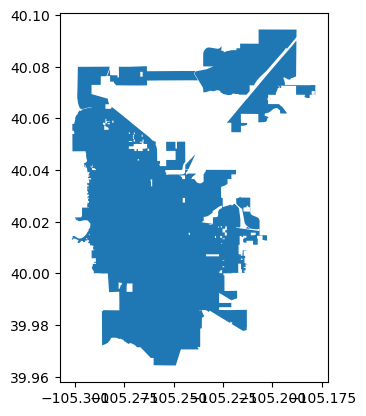

In [47]:
boulder_boundary = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\boulder.shp")
boulder_boundary.plot()

<AxesSubplot:>

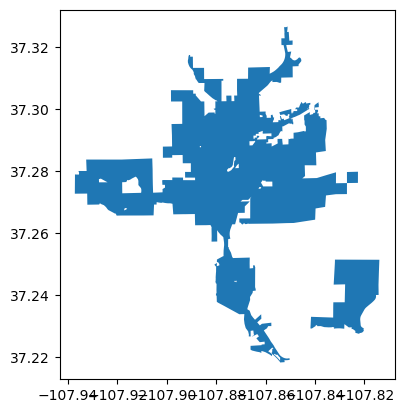

In [48]:
durango_boundary = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\durango.shp")
durango_boundary.plot()

<AxesSubplot:>

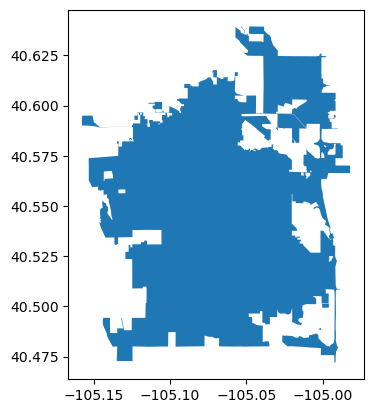

In [49]:
fort_collins_boundary = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\fort_collins.shp")
fort_collins_boundary.plot()

<AxesSubplot:>

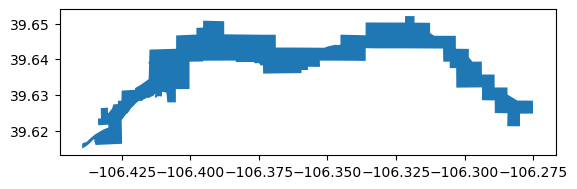

In [50]:
vail_boundary = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\vail.shp")
vail_boundary.plot()

<AxesSubplot:>

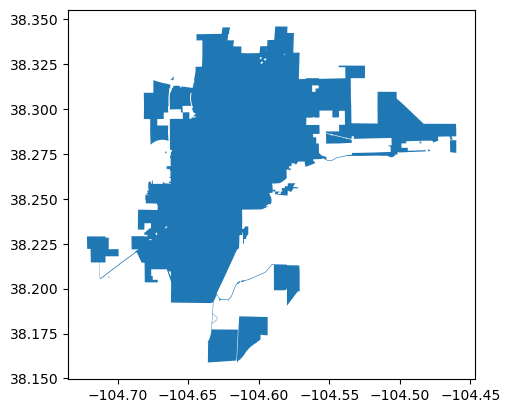

In [51]:
pueblo_boundary = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\pueblo.shp")
pueblo_boundary.plot()

In [52]:
all_within_boulder = trip_program_df_gdf[trip_program_df_gdf.within(boulder_boundary.geometry.iloc[0])]
all_within_durango = trip_program_df_gdf[trip_program_df_gdf.within(durango_boundary.geometry.iloc[0])]
all_within_fortcollins = trip_program_df_gdf[trip_program_df_gdf.within(fort_collins_boundary.geometry.iloc[0])]
all_within_vail = trip_program_df_gdf[trip_program_df_gdf.within(vail_boundary.geometry.iloc[0])]
all_within_pueblo = trip_program_df_gdf[trip_program_df_gdf.within(pueblo_boundary.geometry.iloc[0])]

In [53]:
#denver
#e_bike_start_or_end_within
#car_like_start_or_end_within

#boulder
car_like_start_or_end_within_boulder = car_like_trips[car_like_trips.within(boulder_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_boulder = e_bike_trips[e_bike_trips.within(boulder_boundary.geometry.iloc[0])]

#durango
car_like_start_or_end_within_durango = car_like_trips[car_like_trips.within(durango_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_durango = e_bike_trips[e_bike_trips.within(durango_boundary.geometry.iloc[0])]

#fort collins
car_like_start_or_end_within_fortcollins = car_like_trips[car_like_trips.within(fort_collins_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_fortcollins = e_bike_trips[e_bike_trips.within(fort_collins_boundary.geometry.iloc[0])]

#vail
car_like_start_or_end_within_vail = car_like_trips[car_like_trips.within(vail_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_vail = e_bike_trips[e_bike_trips.within(vail_boundary.geometry.iloc[0])]

#pueblo
car_like_start_or_end_within_pueblo = car_like_trips[car_like_trips.within(pueblo_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_pueblo = e_bike_trips[e_bike_trips.within(pueblo_boundary.geometry.iloc[0])]

In [54]:
e_bike_denver_lessthan5=e_bike_start_or_end_within[e_bike_start_or_end_within['distance_miles']<=5]

In [55]:
e_bike_boulder_lessthan5=e_bike_start_or_end_within_boulder[e_bike_start_or_end_within_boulder['distance_miles']<=5]
e_bike_durango_lessthan5=e_bike_start_or_end_within_durango[e_bike_start_or_end_within_durango['distance_miles']<=5]
e_bike_fortcollins_lessthan5=e_bike_start_or_end_within_fortcollins[e_bike_start_or_end_within_fortcollins['distance_miles']<=5]
e_bike_vail_lessthan5=e_bike_start_or_end_within_vail[e_bike_start_or_end_within_vail['distance_miles']<=5]
e_bike_pueblo_lessthan5=e_bike_start_or_end_within_pueblo[e_bike_start_or_end_within_pueblo['distance_miles']<=5]

<AxesSubplot:>

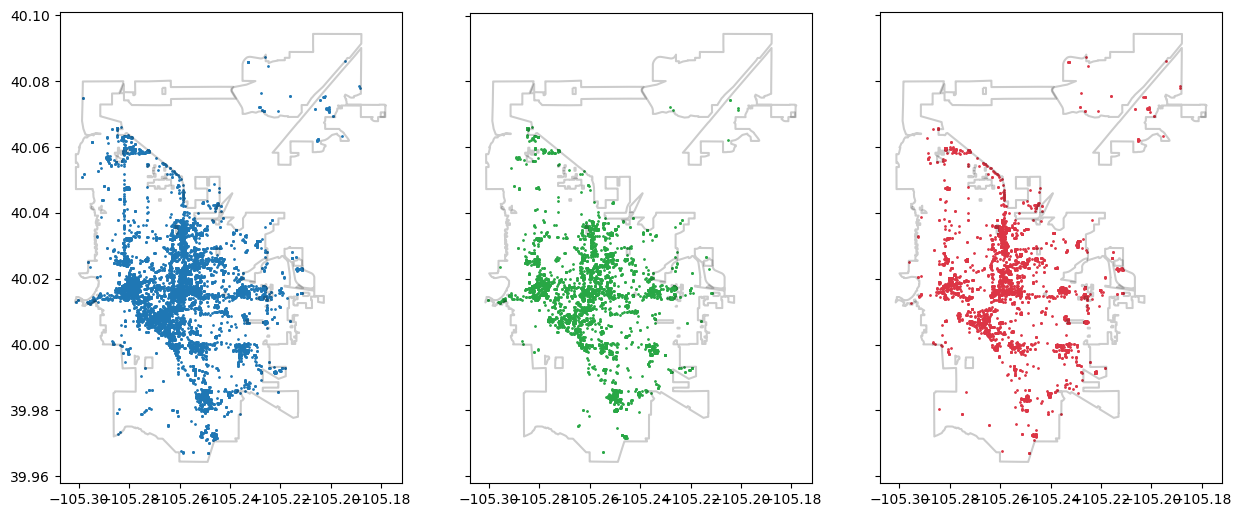

In [117]:
#boulder
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
boulder_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_boulder.plot(ax=ax_arr[0], markersize=1)
boulder_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_boulder.plot(color="#28a745", ax=ax_arr[1], markersize=1)
boulder_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_boulder.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<AxesSubplot:>

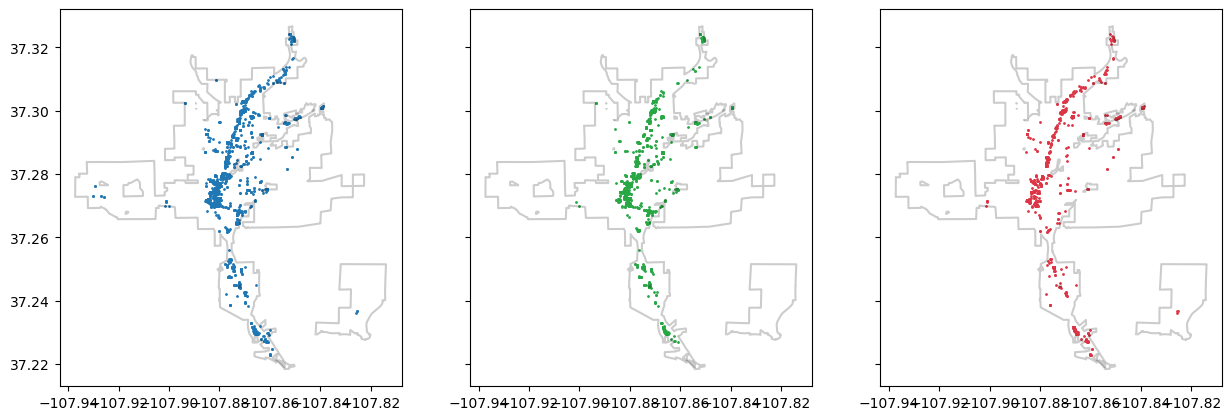

In [119]:
#durango
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
durango_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_durango.plot(ax=ax_arr[0], markersize=1)
durango_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_durango.plot(color="#28a745", ax=ax_arr[1], markersize=1)
durango_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_durango.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<AxesSubplot:>

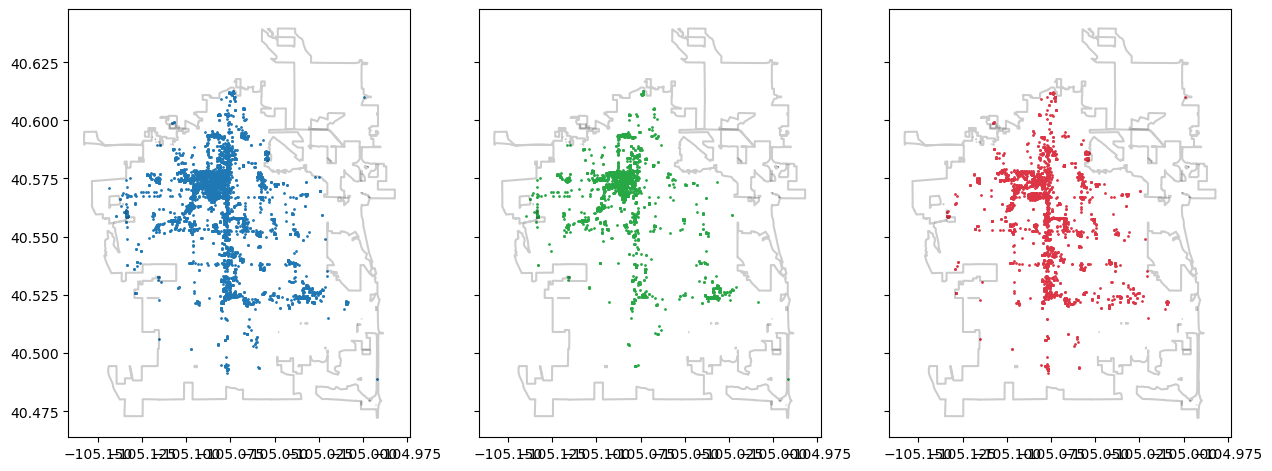

In [118]:
#fort collins
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
fort_collins_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_fortcollins.plot(ax=ax_arr[0], markersize=1)
fort_collins_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_fortcollins.plot(color="#28a745", ax=ax_arr[1], markersize=1)
fort_collins_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_fortcollins.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<AxesSubplot:>

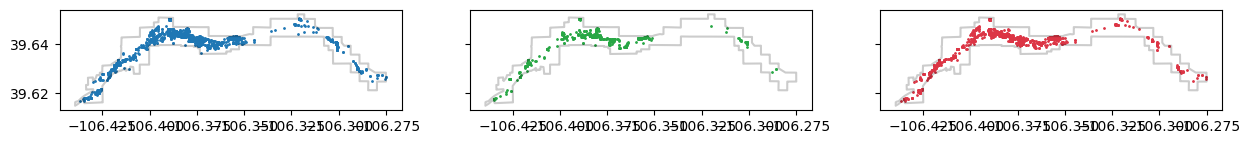

In [120]:
#vail
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
vail_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_vail.plot(ax=ax_arr[0], markersize=1)
vail_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_vail.plot(color="#28a745", ax=ax_arr[1], markersize=1)
vail_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_vail.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<AxesSubplot:>

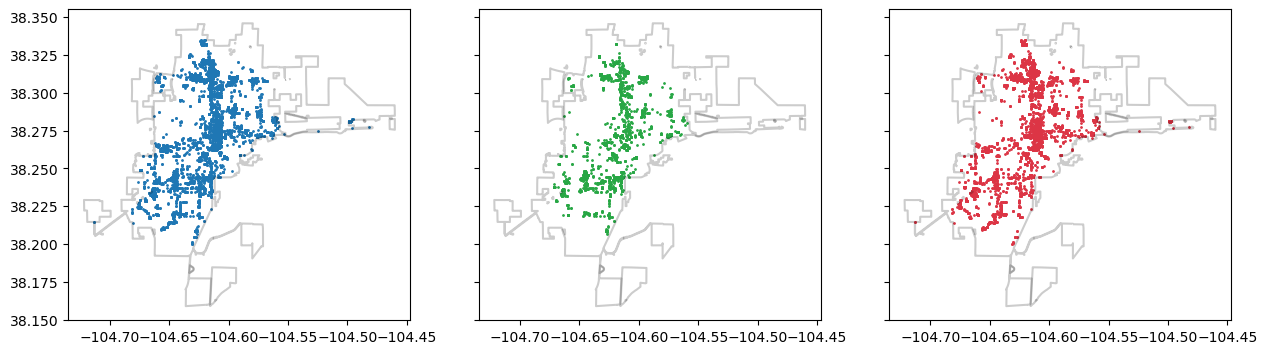

In [121]:
#pueblo
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
pueblo_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_pueblo.plot(ax=ax_arr[0], markersize=1)
pueblo_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_pueblo.plot(color="#28a745", ax=ax_arr[1], markersize=1)
pueblo_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_pueblo.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<AxesSubplot:>

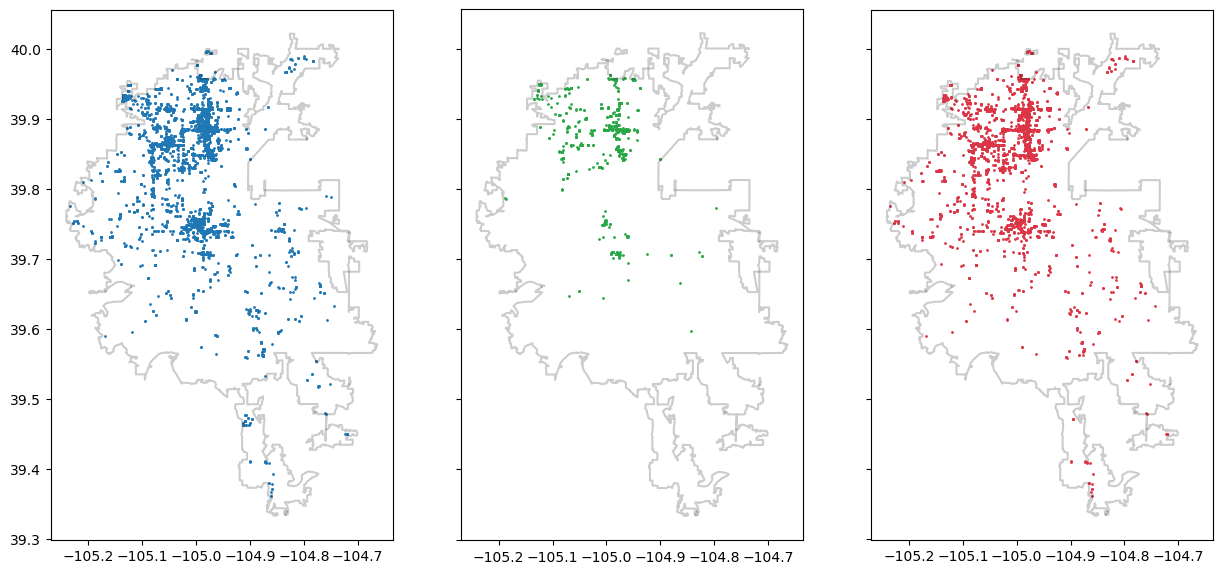

In [122]:
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
denver_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_start_or_end_within.plot(ax=ax_arr[0], markersize=1)
denver_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within.plot(color="#28a745", ax=ax_arr[1], markersize=1)
denver_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

# blocks analysis

In [64]:
denver_blocks = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\denver_blocks.shp")
boulder_blocks= gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\boulder_blocks.shp")
fort_collins_blocks = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\fort_collins_blocks.shp")
vail_blocks = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\vail_blocks.shp")
durango_blocks = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\durango_blocks.shp")
pueblo_blocks = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\pueblo_blocks.shp")

In [56]:
#denver_blocks = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\denver_blocks.shp")
boulder_pixels= gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\boulder_pixels.shp")
fort_collins_pixels = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\fortcollins_pixels.shp")
vail_pixels= gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\vail_pixels.shp")
durango_pixels = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\durango_pixels.shp")
pueblo_pixels = gpd.read_file(r"C:\Users\dakcicek\Desktop\ceo spatial analysis\muni_boundaries\pueblo_pixels.shp")

In [ ]:
#denver First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts(pixel_polygon):
    all_trip_count = np.count_nonzero(all_start_or_end_within.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

In [57]:
# boulder First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_boulder(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_boulder.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_boulder.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_boulder.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# fort collins First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_fortcollins(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_fortcollins.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_fortcollins.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_fortcollins.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# vail First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_vail(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_vail.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_vail.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_vail.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# Durango First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_durango(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_durango.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_durango.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_durango.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# pueblo First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_pueblo(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_pueblo.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_pueblo.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_pueblo.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

In [84]:
#denver_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = denver_blocks.geometry.apply(lambda pp: get_counts(pp))
boulder_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = boulder_blocks.geometry.apply(lambda pp: get_counts_boulder(pp))
fort_collins_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = fort_collins_blocks.geometry.apply(lambda pp: get_counts_fortcollins(pp))
vail_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = vail_blocks.geometry.apply(lambda pp: get_counts_vail(pp))
durango_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = durango_blocks.geometry.apply(lambda pp: get_counts_durango(pp))
pueblo_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = pueblo_blocks.geometry.apply(lambda pp: get_counts_pueblo(pp))

In [58]:
#denver_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = denver_blocks.geometry.apply(lambda pp: get_counts(pp))
boulder_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = boulder_pixels.geometry.apply(lambda pp: get_counts_boulder(pp))
fort_collins_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = fort_collins_pixels.geometry.apply(lambda pp: get_counts_fortcollins(pp))
vail_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = vail_pixels.geometry.apply(lambda pp: get_counts_vail(pp))
durango_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = durango_pixels.geometry.apply(lambda pp: get_counts_durango(pp))
pueblo_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = pueblo_pixels.geometry.apply(lambda pp: get_counts_pueblo(pp))

In [85]:
denver_blocks["e_bike_2_car_like"] = denver_blocks.e_bike_trip_count / denver_blocks.car_like_trip_count
boulder_blocks["e_bike_2_car_like"] = boulder_blocks.e_bike_trip_count / boulder_blocks.car_like_trip_count
fort_collins_blocks["e_bike_2_car_like"] = fort_collins_blocks.e_bike_trip_count / fort_collins_blocks.car_like_trip_count
vail_blocks["e_bike_2_car_like"] = vail_blocks.e_bike_trip_count / vail_blocks.car_like_trip_count
durango_blocks["e_bike_2_car_like"] = durango_blocks.e_bike_trip_count / durango_blocks.car_like_trip_count
pueblo_blocks["e_bike_2_car_like"] = pueblo_blocks.e_bike_trip_count / pueblo_blocks.car_like_trip_count

In [59]:
#denver_blocks["e_bike_2_car_like"] = denver_blocks.e_bike_trip_count / denver_blocks.car_like_trip_count
boulder_pixels["e_bike_2_car_like"] = boulder_pixels.e_bike_trip_count / boulder_pixels.car_like_trip_count
fort_collins_pixels["e_bike_2_car_like"] = fort_collins_pixels.e_bike_trip_count / fort_collins_pixels.car_like_trip_count
vail_pixels["e_bike_2_car_like"] = vail_pixels.e_bike_trip_count / vail_pixels.car_like_trip_count
durango_pixels["e_bike_2_car_like"] = durango_pixels.e_bike_trip_count / durango_pixels.car_like_trip_count
pueblo_pixels["e_bike_2_car_like"] = pueblo_pixels.e_bike_trip_count / pueblo_pixels.car_like_trip_count

In [86]:
denver_blocks.replace(np.inf, denver_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
boulder_blocks.replace(np.inf, boulder_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
fort_collins_blocks.replace(np.inf, fort_collins_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
vail_blocks.replace(np.inf, vail_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
durango_blocks.replace(np.inf, durango_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
pueblo_blocks.replace(np.inf, pueblo_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)

In [60]:
#denver_blocks.replace(np.inf, denver_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
boulder_pixels.replace(np.inf, boulder_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
fort_collins_pixels.replace(np.inf, fort_collins_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
vail_pixels.replace(np.inf, vail_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
durango_pixels.replace(np.inf, durango_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
pueblo_pixels.replace(np.inf, pueblo_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)

In [122]:
denver_blocks["e_bike_better"] = pd.Categorical(denver_blocks.e_bike_2_car_like >= 1)
boulder_blocks["e_bike_better"] = pd.Categorical(boulder_blocks.e_bike_2_car_like >= 1)
fort_collins_blocks["e_bike_better"] = pd.Categorical(fort_collins_blocks.e_bike_2_car_like >= 1)
vail_blocks["e_bike_better"] = pd.Categorical(vail_blocks.e_bike_2_car_like >= 1)
durango_blocks["e_bike_better"] = pd.Categorical(durango_blocks.e_bike_2_car_like >= 1)
pueblo_blocks["e_bike_better"] = pd.Categorical(pueblo_blocks.e_bike_2_car_like >= 1)

In [61]:
#denver_blocks["e_bike_better"] = pd.Categorical(denver_blocks.e_bike_2_car_like >= 1)
boulder_pixels["e_bike_better"] = pd.Categorical(boulder_pixels.e_bike_2_car_like >= 1)
fort_collins_pixels["e_bike_better"] = pd.Categorical(fort_collins_pixels.e_bike_2_car_like >= 1)
vail_pixels["e_bike_better"] = pd.Categorical(vail_pixels.e_bike_2_car_like >= 1)
durango_pixels["e_bike_better"] = pd.Categorical(durango_pixels.e_bike_2_car_like >= 1)
pueblo_pixels["e_bike_better"] = pd.Categorical(pueblo_pixels.e_bike_2_car_like >= 1)

In [137]:
denver_blocks_2 = denver_blocks[denver_blocks['e_bike_2_car_like'].notna()]
boulder_blocks_2 = boulder_blocks[boulder_blocks['e_bike_2_car_like'].notna()]
fort_collins_blocks_2 = fort_collins_blocks[fort_collins_blocks['e_bike_2_car_like'].notna()]
vail_blocks_2 = vail_blocks[vail_blocks['e_bike_2_car_like'].notna()]
durango_blocks_2 = durango_blocks[durango_blocks['e_bike_2_car_like'].notna()]
pueblo_blocks_2 = pueblo_blocks[pueblo_blocks['e_bike_2_car_like'].notna()]

In [62]:
#denver_blocks_2 = denver_blocks[denver_blocks['e_bike_2_car_like'].notna()]
boulder_pixels_2 = boulder_pixels[boulder_pixels['e_bike_2_car_like'].notna()]
fort_collins_pixels_2 = fort_collins_pixels[fort_collins_pixels['e_bike_2_car_like'].notna()]
vail_pixels_2 = vail_pixels[vail_pixels['e_bike_2_car_like'].notna()]
durango_pixels_2 = durango_pixels[durango_pixels['e_bike_2_car_like'].notna()]
pueblo_pixels_2 = pueblo_pixels[pueblo_pixels['e_bike_2_car_like'].notna()]

<AxesSubplot:>

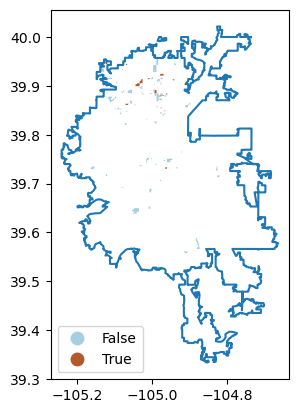

In [138]:
ax = denver_boundary.boundary.plot()
denver_blocks_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:>

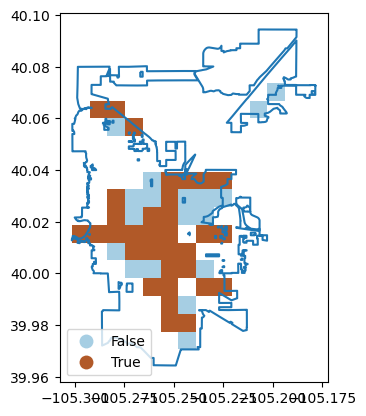

In [63]:
ax = boulder_boundary.boundary.plot()
boulder_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:>

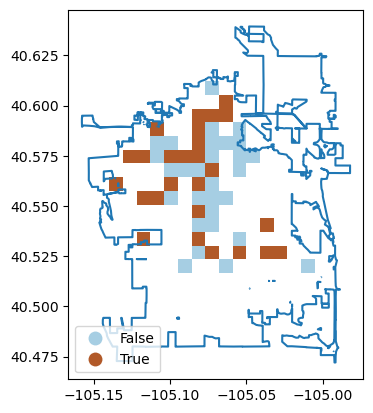

In [64]:
ax = fort_collins_boundary.boundary.plot()
fort_collins_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:>

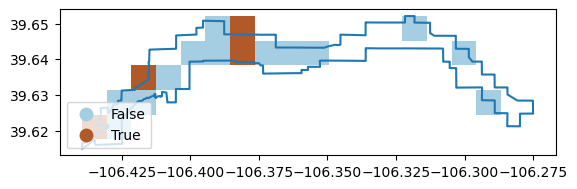

In [65]:
ax = vail_boundary.boundary.plot()
vail_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:>

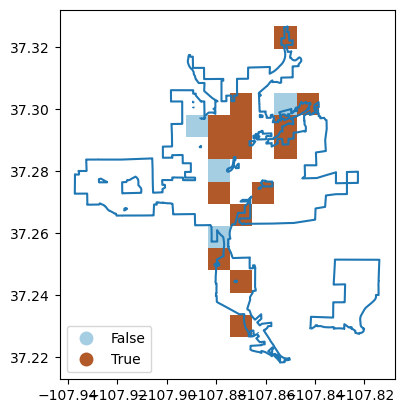

In [66]:
ax = durango_boundary.boundary.plot()
durango_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:>

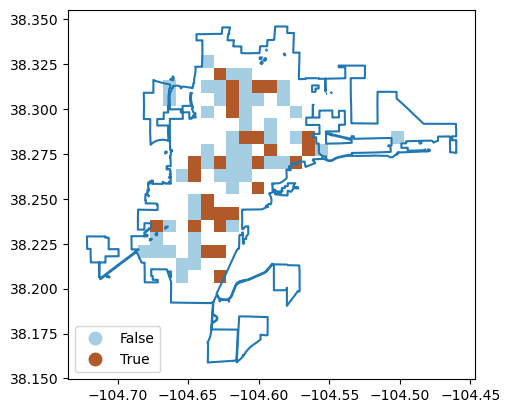

In [67]:
ax = pueblo_boundary.boundary.plot()
pueblo_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

<AxesSubplot:title={'center':'Blocks where e-bikes are used more often than driving'}, ylabel='GEOID20'>

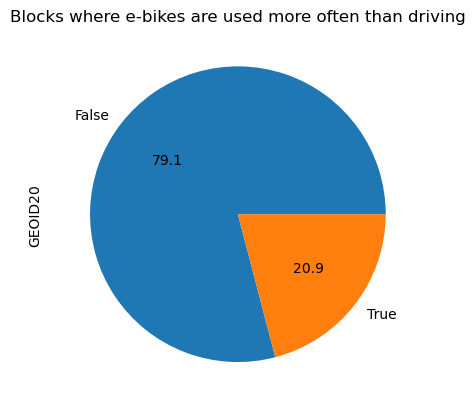

In [147]:
denver_blocks_2.groupby("e_bike_better").count().GEOID20.plot(kind="pie", autopct='%.1f', title="Blocks where e-bikes are used more often than driving")

<AxesSubplot:title={'center':'Pixels where e-bikes are used more often than driving'}, ylabel='id'>

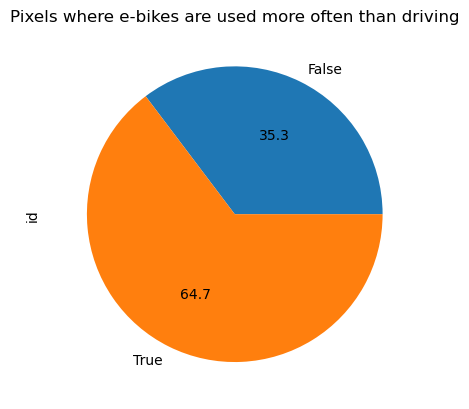

In [68]:
boulder_pixels_2.groupby("e_bike_better").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bikes are used more often than driving")

<AxesSubplot:title={'center':'Pixels where e-bikes are used more often than driving'}, ylabel='id'>

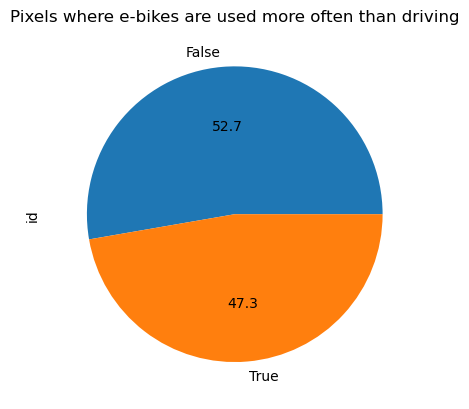

In [69]:
fort_collins_pixels_2.groupby("e_bike_better").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bikes are used more often than driving")

<AxesSubplot:title={'center':'Pixels where e-bikes are used more often than driving'}, ylabel='id'>

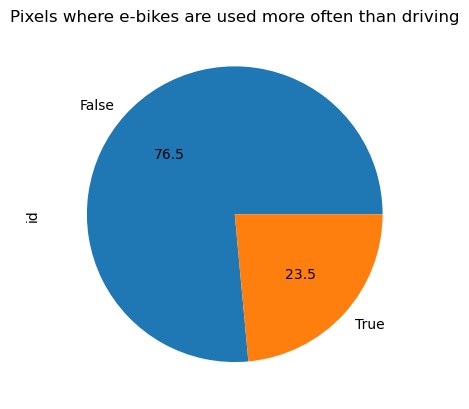

In [70]:
vail_pixels_2.groupby("e_bike_better").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bikes are used more often than driving")

<AxesSubplot:title={'center':'Pixels where e-bikes are used more often than driving'}, ylabel='id'>

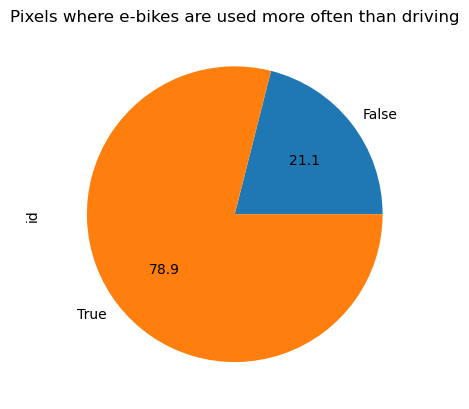

In [71]:
durango_pixels_2.groupby("e_bike_better").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bikes are used more often than driving")

<AxesSubplot:title={'center':'Pixels where e-bikes are used more often than driving'}, ylabel='id'>

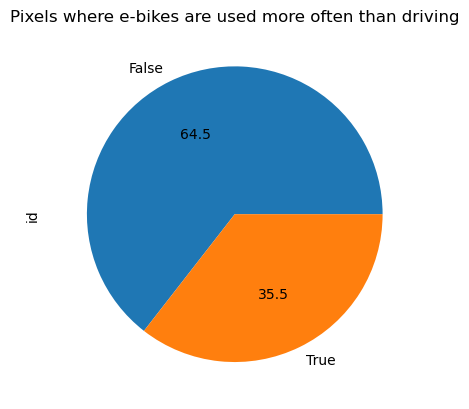

In [72]:
pueblo_pixels_2.groupby("e_bike_better").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bikes are used more often than driving")

In [73]:
#denver_blocks_2["e_bike_gt_50_pct"] = pd.Categorical(denver_blocks_2.e_bike_2_car_like >= 0.5)
boulder_pixels_2["e_bike_gt_50_pct"] = pd.Categorical(boulder_pixels_2.e_bike_2_car_like >= 0.5)
fort_collins_pixels_2["e_bike_gt_50_pct"] = pd.Categorical(fort_collins_pixels_2.e_bike_2_car_like >= 0.5)
vail_pixels_2["e_bike_gt_50_pct"] = pd.Categorical(vail_pixels_2.e_bike_2_car_like >= 0.5)
durango_pixels_2["e_bike_gt_50_pct"] = pd.Categorical(durango_pixels_2.e_bike_2_car_like >= 0.5)
pueblo_pixels_2["e_bike_gt_50_pct"] = pd.Categorical(pueblo_pixels_2.e_bike_2_car_like >= 0.5)

C:\Users\dakcicek\Anaconda3\envs\tsdc_ops\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
denver_blocks_2.groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Blocks where e-bike trips are least 50% of driving trips")

<AxesSubplot:title={'center':'Pixels where e-bike trips are least 50% of driving trips'}, ylabel='id'>

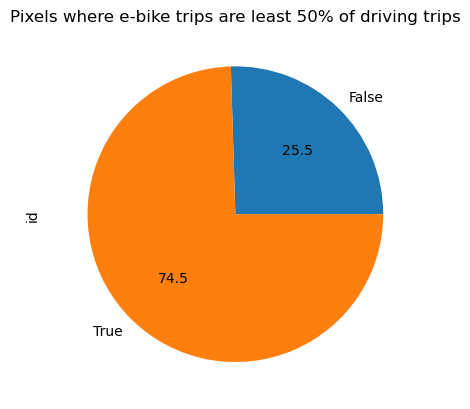

In [74]:
boulder_pixels_2.groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bike trips are least 50% of driving trips")

<AxesSubplot:title={'center':'Pixels where e-bike trips are least 50% of driving trips'}, ylabel='id'>

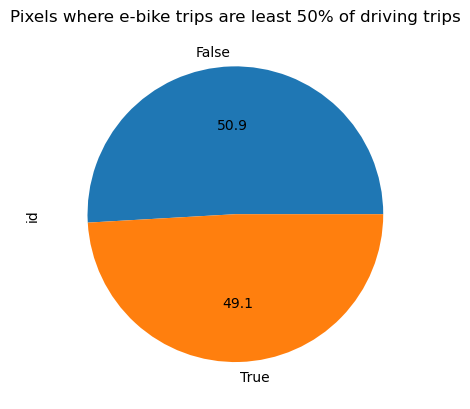

In [75]:
fort_collins_pixels_2.groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bike trips are least 50% of driving trips")

<AxesSubplot:title={'center':'Pixels where e-bike trips are least 50% of driving trips'}, ylabel='id'>

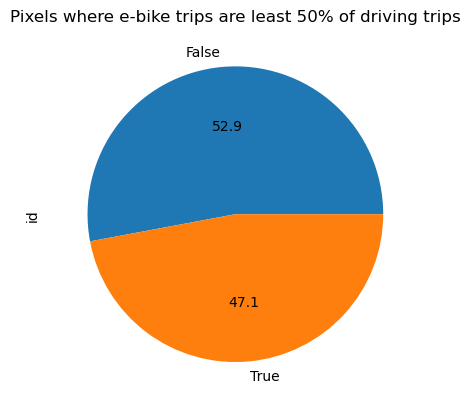

In [76]:
vail_pixels_2.groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bike trips are least 50% of driving trips")

<AxesSubplot:title={'center':'Pixels where e-bike trips are least 50% of driving trips'}, ylabel='id'>

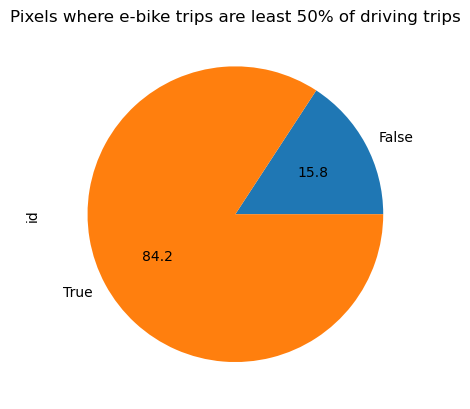

In [77]:
durango_pixels_2.groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bike trips are least 50% of driving trips")

<AxesSubplot:title={'center':'Pixels where e-bike trips are least 50% of driving trips'}, ylabel='id'>

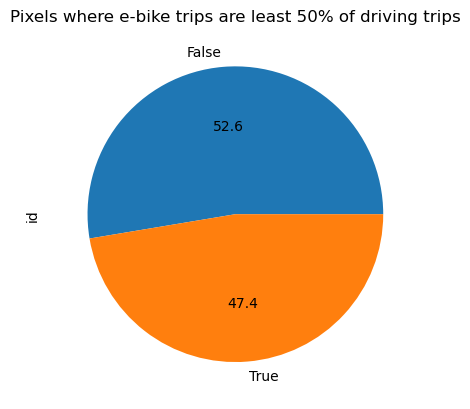

In [78]:
pueblo_pixels_2.groupby("e_bike_gt_50_pct").count().id.plot(kind="pie", autopct='%.1f', title="Pixels where e-bike trips are least 50% of driving trips")